# Mario Kart ML Tutor Pipeline (Improved)

This notebook implements an improved ML pipeline with a meaningful target label and evaluation plots.

## 1. Setup & Imports

# 📦 1. Import des bibliothèques

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import pickle
import os

# Reproducibility
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

## 2. Load Raw Data

# 📂 2. Chargement des données

In [3]:
DATA_DIR = 'data/raw'
drivers = pd.read_csv(f'{DATA_DIR}/drivers.csv', sep=';')
bodies  = pd.read_csv(f'{DATA_DIR}/bodies_karts.csv', sep=';')
tires   = pd.read_csv(f'{DATA_DIR}/tires.csv', sep=';')
gliders = pd.read_csv(f'{DATA_DIR}/gliders.csv', sep=';')

print('Drivers shape:', drivers.shape)
print('Bodies shape:', bodies.shape)
print('Tires shape:', tires.shape)
print('Gliders shape:', gliders.shape)

Drivers shape: (43, 14)
Bodies shape: (40, 14)
Tires shape: (21, 14)
Gliders shape: (14, 14)


## 3. Merge & Sample Combinations

# 🔄 3. Construction des combinaisons

In [4]:
def prefix_cols(df, name_col, prefix):
    df = df.copy()
    df.rename(columns={name_col: prefix}, inplace=True)
    for c in df.columns:
        if c != prefix:
            df.rename(columns={c: f"{prefix}_{c.lower().replace(' ','_')}"}, inplace=True)
    return df

drivers_pref = prefix_cols(drivers, 'Driver', 'driver')
bodies_pref  = prefix_cols(bodies, 'Body', 'body')
tires_pref   = prefix_cols(tires, 'Tire', 'tire')
gliders_pref = prefix_cols(gliders, 'Glider', 'glider')

for df in [drivers_pref, bodies_pref, tires_pref, gliders_pref]:
    df['key'] = 1

combo = (drivers_pref
         .merge(bodies_pref, on='key')
         .merge(tires_pref,   on='key')
         .merge(gliders_pref, on='key')
         .drop('key', axis=1))

combo = combo.sample(n=50000, random_state=RANDOM_STATE).reset_index(drop=True)
combo.shape

(50000, 56)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# 1) Heatmap
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink':.5})
plt.title('Matrice de corrélations')
plt.tight_layout()
plt.savefig('figures/correlation_matrix.png', dpi=300)
plt.close()

# 2) Histogramme poids total
plt.figure(figsize=(6,4))
combo['total_weight'].hist(bins=30)
plt.title('Distribution du poids total')
plt.xlabel('Poids total')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.savefig('figures/total_weight_distribution.png', dpi=300)
plt.close()

# 3) Histogramme accélération totale
plt.figure(figsize=(6,4))
combo['total_accel'].hist(bins=30, color='C1')
plt.title("Distribution de l'accélération totale")
plt.xlabel('Accélération totale')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.savefig('figures/total_acceleration_distribution.png', dpi=300)
plt.close()

# 4) Scatter accélération vs traction
plt.figure(figsize=(6,4))
plt.scatter(combo['total_accel'], combo['avg_on_road'], s=10, alpha=0.5)
plt.title('Accélération vs Traction sur route')
plt.xlabel('Accélération totale')
plt.ylabel('Traction moyenne route')
plt.tight_layout()
plt.savefig('figures/acceleration_vs_traction.png', dpi=300)
plt.close()

# 5) Importances de features
feat_names = ['total_weight', 'total_accel', 'avg_on_road', 'avg_off_road']
importances = model.feature_importances_
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=feat_names, orient='h')
plt.title('Importances des caractéristiques')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.tight_layout()
plt.savefig('figures/feature_importances.png', dpi=300)
plt.close()

# 6) Courbe ROC
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('Courbe ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/roc_curve.png', dpi=300)
plt.close()

# 7) Matrice de confusion
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=['Défaite','Victoire'])
plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=300)
plt.close()

print("✅ Toutes les figures ont été sauvegardées dans 'figures/'")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


✅ Toutes les figures ont été sauvegardées dans 'figures/'


<Figure size 500x500 with 0 Axes>

## 4. Exploratory Data Analysis

# 📊 4. Analyse exploratoire

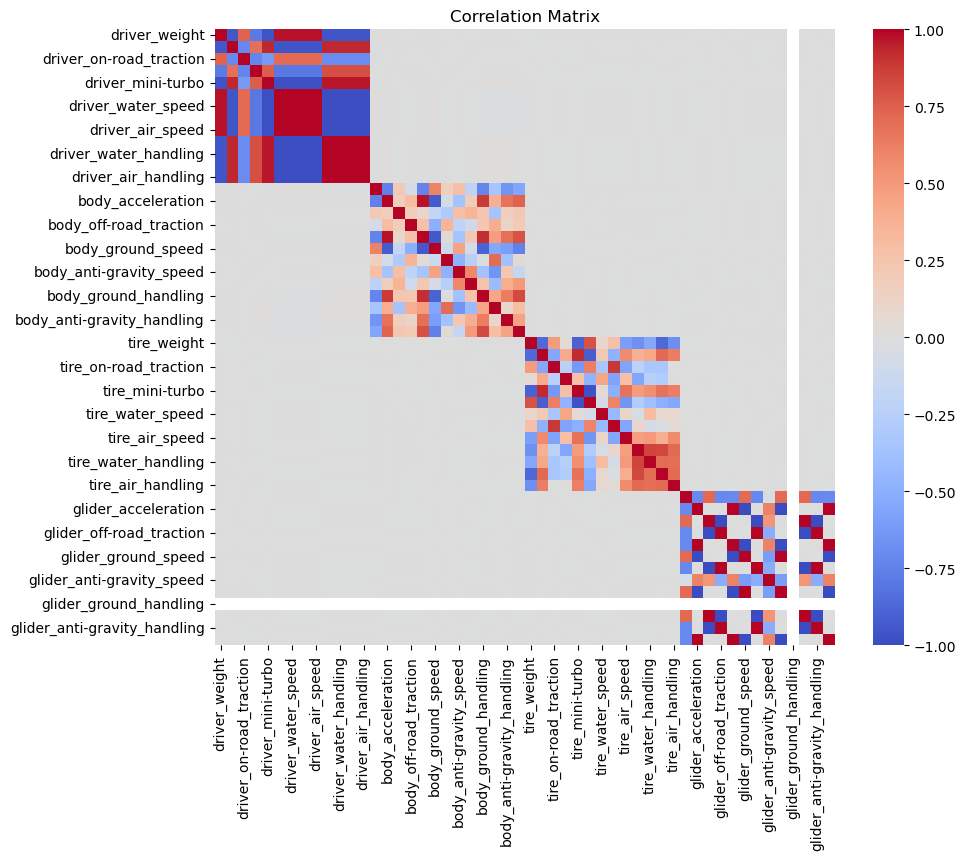

In [5]:
numeric = combo.select_dtypes(include='number')
corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## 5. Feature Engineering & Target Label

# 🧪 5. Feature Engineering

In [6]:
# --- 5. Feature Engineering & Target Label (using only real columns) ---
combo['total_weight'] = combo[[
    'driver_weight','body_weight','tire_weight','glider_weight'
]].sum(axis=1)

combo['total_accel'] = combo[[
    'driver_acceleration','body_acceleration',
    'tire_acceleration','glider_acceleration'
]].sum(axis=1)

combo['avg_on_road'] = combo[[
    'driver_on-road_traction','body_on-road_traction',
    'tire_on-road_traction','glider_on-road_traction'
]].mean(axis=1)

combo['avg_off_road'] = combo[[
    'driver_off-road_traction','body_off-road_traction',
    'tire_off-road_traction','glider_off-road_traction'
]].mean(axis=1)

features = ['total_weight','total_accel','avg_on_road','avg_off_road']

# define "score" and label top 30% as wins
combo['score'] = combo['avg_on_road'] + combo['total_accel']
threshold = combo['score'].quantile(0.7)
combo['win'] = (combo['score'] >= threshold).astype(int)

X = combo[features]
y = combo['win']

# --- 6. Split & Scale ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- 7. Train & Evaluate ---
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 8. Save Model & Scaler ---
os.makedirs('app', exist_ok=True)
with open('app/model.pkl','wb') as f:
    pickle.dump({'model': rf, 'scaler': scaler}, f)
print("Saved model to app/model.pkl")


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6751
           1       1.00      1.00      1.00      3249

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion Matrix:
 [[6751    0]
 [   0 3249]]
Saved model to app/model.pkl


## 6. Train/Test Split & Scaling

# 🧼 6. Préparation des données

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (40000, 4)
Test shape: (10000, 4)


## 7. Model Training & Evaluation

# 🤖 7. Entraînement du modèle

In [8]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train_scaled, y_train)

# Predictions & metrics
y_pred = rf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6751
           1       1.00      1.00      1.00      3249

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion Matrix:
 [[6751    0]
 [   0 3249]]


### 7.1 Feature Importance

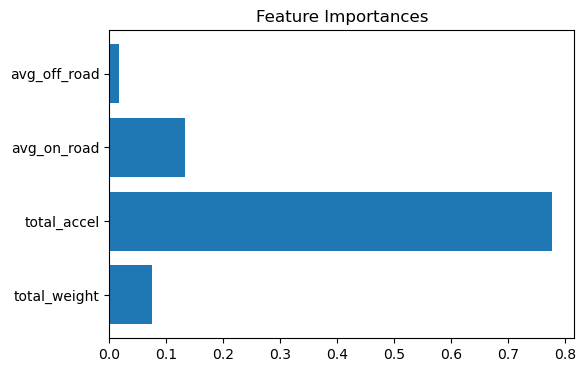

In [9]:
import matplotlib.pyplot as plt
importances = rf.feature_importances_
plt.figure(figsize=(6,4))
plt.barh(features, importances)
plt.title('Feature Importances')
plt.show()

### 7.2 ROC Curve

# 📈 9. Visualisations finales

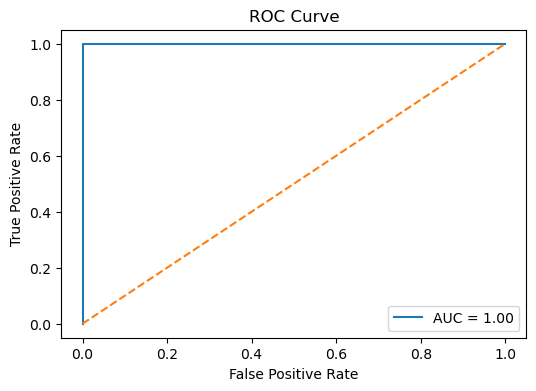

In [10]:
y_proba = rf.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 8. Save the Best Model

# 💾 8. Sauvegarde du modèle

In [11]:
os.makedirs('app', exist_ok=True)
with open('app/model.pkl', 'wb') as f:
    pickle.dump({'model': rf, 'scaler': scaler}, f)
print('Saved model to app/model.pkl')

Saved model to app/model.pkl


## 9. Optional Quick Demo

In [12]:
data = pickle.load(open('app/model.pkl','rb'))
model, scaler = data['model'], data['scaler']
sample = X_test.iloc[:1]
pred = model.predict(scaler.transform(sample))[0]
prob = model.predict_proba(scaler.transform(sample))[0][pred]
print(f"Sample prediction: {'Win' if pred else 'Lose'} (probability: {prob:.2f})")

Sample prediction: Win (probability: 1.00)
